# Artificial Cells

In this notebook, we will use the noise functions in `src/noise/noise.py` to generate an artificial actomyosin cortex.

In [23]:
import numpy as np 
import os
import tifffile

Make sure to run `pip install -e .` before running the cell below. This command will make sure `diet4cola` is installed as a module in your current Python/Conda environment.

In [24]:
from diet4cola.generation.noise import *
from diet4cola.generation.operations import *
from diet4cola.generation.masks import *
from diet4cola.utils import *

## Actomyosin Cortex

Let's recap what an actomyosin cortex looks like. We load one of the examples from the dataset.

In [25]:
experiment = '220530-E1_Out'

# Reading in the image from the associated experiment
image_dir = '../data/tiff'
image_file = [f for f in os.listdir(image_dir) if experiment in f and f.endswith('.tiff')] # type: ignore
if len(image_file) > 1:
    raise ValueError(f'Expected only one image for experiment {experiment}, but found {len(image_file)}')

image = tifffile.TiffFile(f'{image_dir}/{image_file[0]}')
image_data = np.squeeze(image.asarray())

# Preparation for visual plotting
channel_red     = image_data[0]                     # shape -> (115, 512, 512)
channel_green   = image_data[1]                     # shape -> (115, 512, 512)
channel_blue    = np.zeros(channel_green.shape)     # shape -> (115, 512, 512)

# Normalize for visualization 
channel_red_norm    = (channel_red - channel_red.min()) / (channel_red.max() - channel_red.min()) 
channel_green_norm  = (channel_green - channel_green.min()) / (channel_green.max() - channel_green.min())

# Create RG(B) stack for each slice
rgb_stack = np.zeros((115, 512, 512, 3), dtype=np.float32)
rgb_stack[..., 0] = channel_red_norm    # Red -> Myosin
rgb_stack[..., 1] = channel_green_norm  # Green -> Actin
rgb_stack[..., 2] = channel_blue        # Blue

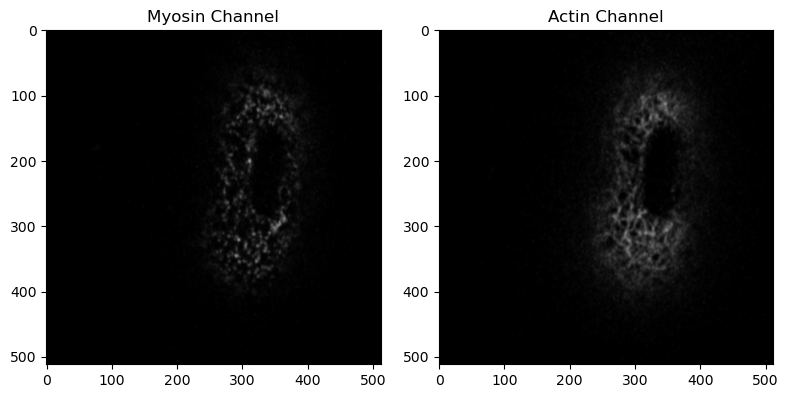

In [26]:
plot_2d_array_comparison(rgb_stack[4, :, :, 0], rgb_stack[4, :, :, 1], 'Myosin Channel', 'Actin Channel')

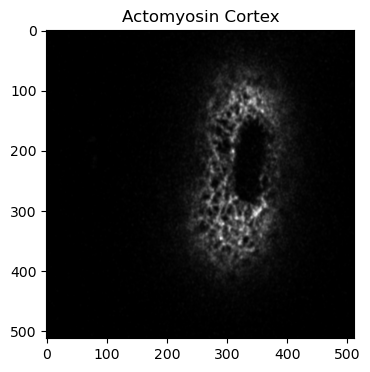

In [27]:
real_actomyosin_cortex = normalize(add(rgb_stack[4, :, :, 0], rgb_stack[4, :, :, 1]))
plot_2d_array(real_actomyosin_cortex, 'Actomyosin Cortex')

## Building Actomyosin Cortex

We can now start to build an actomyosin cortex. We first create a cell mask that will act as the visible part of our artificial actomyosin cortex. 

In [36]:
seed = 1
width = 512
height = 512

np.random.seed(seed)
off_x = 256 + (np.random.randint(32) - 16)
off_y = 256 + (np.random.randint(32) - 16)

cell_mask_layer, (cell_extent_a, cell_extent_b), cell_angle = cell_mask(width, height, (off_x, off_y), (200, 200), 50, seed)

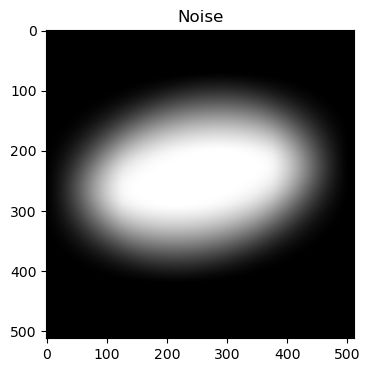

In [29]:
plot_2d_array(cell_mask_layer)

Next, we generate an artificial myosin layer.

In [34]:
myosin_layer = myosin_noise(width, height, seed = seed, iterations=10)
myosin_layer = mul(myosin_layer, cell_mask_layer)

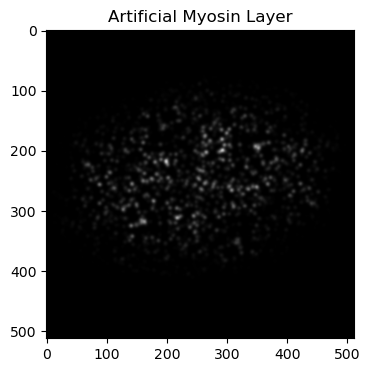

In [35]:
plot_2d_array(myosin_layer, 'Artificial Myosin Layer')

Next, we generate an artificial actin layer.

In [32]:
actin_layer = actin_noise(width, height, cell_mask_layer, 2560, -0.05, seed)
actin_layer = mul(actin_layer, cell_mask_layer)

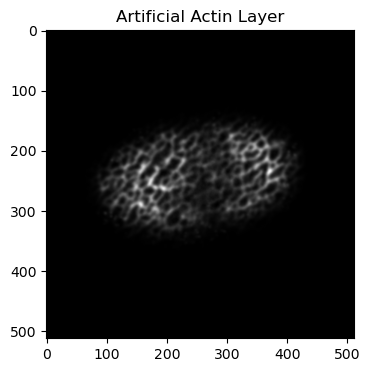

In [33]:
plot_2d_array(actin_layer, 'Artificial Actin Layer')

Combining the myosin and actin layers, we obtain the final actomyosin cortex representation.

In [37]:
actomyosin_layer = add(myosin_layer, actin_layer)
actomyosin_layer = normalize(actomyosin_layer)

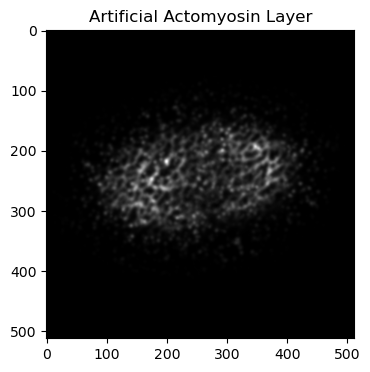

In [39]:
plot_2d_array(actomyosin_layer, 'Artificial Actomyosin Layer')